# **Multimodal neurons**

---

This is the structure in which we have organized our code:
```
├── data/                           	# -> Data folder
└── results/                            # -> Results of our experiments
```

## Environment configuration

In [1]:
# For running this project in a hosted runtime

# Mount drive
# from google.colab import drive
# drive.mount('/content/drive')

# Project directory (change this to the Google Drive directory in which you have saved the project)
# %cd /content/drive/MyDrive/university/roes/multimodal neurons/

# Choose your path (for collaboration) - run in a hosted runtime
# curr_path = "/content/drive/MyDrive/university/roes/multimodal neurons/"

curr_path = "./" # run locally

In [2]:
# Environment configuration

# Dependencies and imports
# !pip install torch torchvision torchaudio ftfy regex tqdm deeplake
# !pip install git+https://github.com/openai/CLIP.git # CLIP
# !pip install torch-lucent
# !pip install git+https://github.com/microsoft/CLAP.git # CLAP
# !pip install laion-clap # or this implementation of CLAP

import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import random
import os
import torch.nn as nn
from tqdm import tqdm
import time
import re
import itertools
import warnings
from PIL import Image
from torchvision import transforms
import clip
from msclap import CLAP
import laion_clap
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import deeplake

from lucent.optvis import render, param, transform, objectives
from lucent.misc.io.showing import animate_sequence
from lucent.modelzoo.util import get_model_layers
from lucent.misc.io import show

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Data
data_path = curr_path + "data/"

## CLIP model

In [3]:
# CLIP available models

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
# Load the CLIP model

model, preprocess = clip.load("RN50x4", device=device)
model.eval()

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

## Zero-shot classification

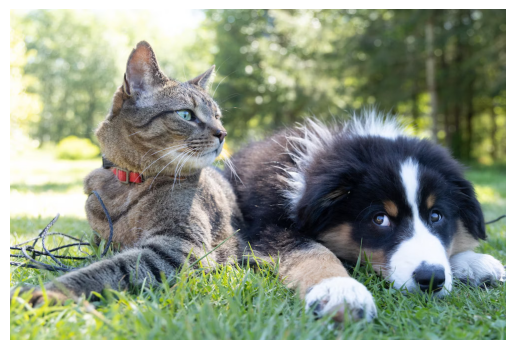

This is a dog: 0.0014295578002929688
This is a cat: 0.0018072128295898438
This is a dog and a cat: 0.99658203125


In [5]:
# Example usage (zero-shot classification)

# Show image
image = Image.open(data_path + "dog_cat.jpg")
plt.imshow(image)
plt.axis('off')
plt.show()

# Preprocess image
image = preprocess(Image.open(data_path + "dog_cat.jpg")).unsqueeze(0).to(device)

# Tokenize text
texts = ["This is a dog", "This is a cat", "This is a dog and a cat"]
text_tokens = clip.tokenize(texts).to(device)

# Calculate similarity
with torch.no_grad():
  image_features = model.encode_image(image)
  text_features = model.encode_text(text_tokens)

  logits_per_image, logits_per_text = model(image, text_tokens)
  probs = logits_per_image.softmax(dim=-1).cpu().numpy()

for i, text in enumerate(texts):
    print(f"{text}: {probs[0][i]}")

## Feature visualization

In [5]:
# Vision side of the CLIP model

vision_side = model.visual

In [16]:
# Vision side model layers

layers = get_model_layers(vision_side)
print(layers)

['conv1', 'bn1', 'relu1', 'conv2', 'bn2', 'relu2', 'conv3', 'bn3', 'relu3', 'avgpool', 'layer1', 'layer1_0', 'layer1_0_conv1', 'layer1_0_bn1', 'layer1_0_relu1', 'layer1_0_conv2', 'layer1_0_bn2', 'layer1_0_relu2', 'layer1_0_avgpool', 'layer1_0_conv3', 'layer1_0_bn3', 'layer1_0_relu3', 'layer1_0_downsample', 'layer1_0_downsample_-1', 'layer1_0_downsample_0', 'layer1_0_downsample_1', 'layer1_1', 'layer1_1_conv1', 'layer1_1_bn1', 'layer1_1_relu1', 'layer1_1_conv2', 'layer1_1_bn2', 'layer1_1_relu2', 'layer1_1_avgpool', 'layer1_1_conv3', 'layer1_1_bn3', 'layer1_1_relu3', 'layer1_2', 'layer1_2_conv1', 'layer1_2_bn1', 'layer1_2_relu1', 'layer1_2_conv2', 'layer1_2_bn2', 'layer1_2_relu2', 'layer1_2_avgpool', 'layer1_2_conv3', 'layer1_2_bn3', 'layer1_2_relu3', 'layer1_3', 'layer1_3_conv1', 'layer1_3_bn1', 'layer1_3_relu1', 'layer1_3_conv2', 'layer1_3_bn2', 'layer1_3_relu2', 'layer1_3_avgpool', 'layer1_3_conv3', 'layer1_3_bn3', 'layer1_3_relu3', 'layer2', 'layer2_0', 'layer2_0_conv1', 'layer2_0_bn

100%|███████████████████████████████████████████████████| 512/512 [00:26<00:00, 19.55it/s]



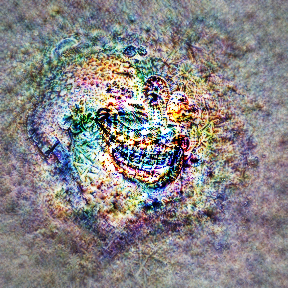

In [23]:
# Define the layer and neuron/channel for feature visualization

# Note:
# * Channel optimization objective results in a repeating pattern
# * Neuron optimization objective shows spatial preferences

layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"
image_path = f"results/feature_vis_neuron_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True)
obj = objectives.neuron(layer_name, neuron_channel_index)

_ = render.render_vis(vision_side, obj, batch_param_f, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))
# _ = render.render_vis(vision_side, "layer3_3_conv3:168", show_inline=True) # or this

100%|███████████████████████████████████████████████████| 512/512 [00:29<00:00, 17.31it/s]



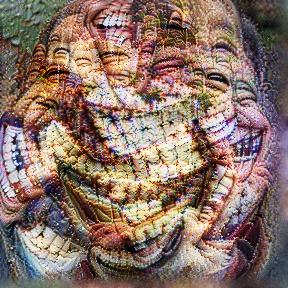

In [24]:
# Here we try different tranformations (regularizers)

layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"
image_path = f"results/feature_vis_neuron_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True)
obj = objectives.channel(layer_name, neuron_channel_index)

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2)
]

_ = render.render_vis(vision_side, obj, batch_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

100%|███████████████████████████████████████████████████| 512/512 [00:26<00:00, 19.37it/s]



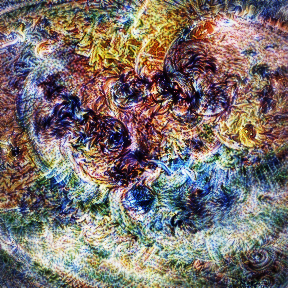

In [26]:
# Define the layer and neuron/channel for feature visualization - deepdream

layer_name = "layer4_5_conv3"
image_path = f"results/feature_vis_deepdream_{layer_name}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True)
obj = objectives.deepdream(layer_name)

_ = render.render_vis(vision_side, obj, batch_param_f, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

100%|███████████████████████████████████████████████████| 512/512 [00:56<00:00,  9.01it/s]



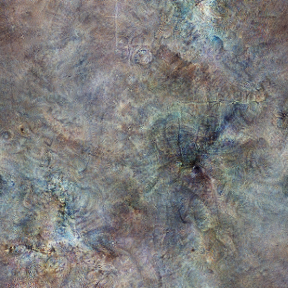
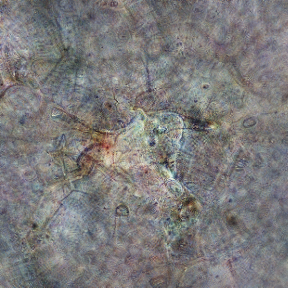
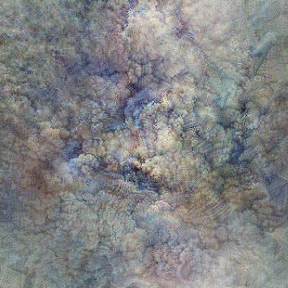
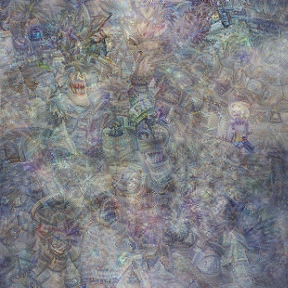

In [37]:
# Diversity -> this needs further investigation

layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy
image_path = f"results/feature_vis_diversity_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=4, decorrelate=True)
obj = objectives.channel(layer_name, neuron_channel_index) - 1e3 * objectives.diversity(layer_name)

_ = render.render_vis(vision_side, obj, batch_param_f, show_inline=True, save_image=True, image_name=image_path)

In [ ]:
# Neural interactions (combined neurons, etc.) -> very interesting, we will delve into this as soon as possible

...

## Feature inversion - caricatures

In [ ]:
# I will write the code shortly...

## Dataset samples

### **PACS dataset**

In [6]:
# Load the PACS dataset

pacs_ds = deeplake.load("hub://activeloop/pacs-train")

-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-train



\

hub://activeloop/pacs-train loaded successfully.



In [7]:
# Dataloader

tform = transforms.Compose([ # transforms
    transforms.ToPILImage(),
    preprocess # CLIP preprocessing
])

batch_size = 4 # batch size

dataloader = pacs_ds.pytorch(batch_size=batch_size, num_workers=0, # dataloader
    transform = {'images': tform, 'labels': None}, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


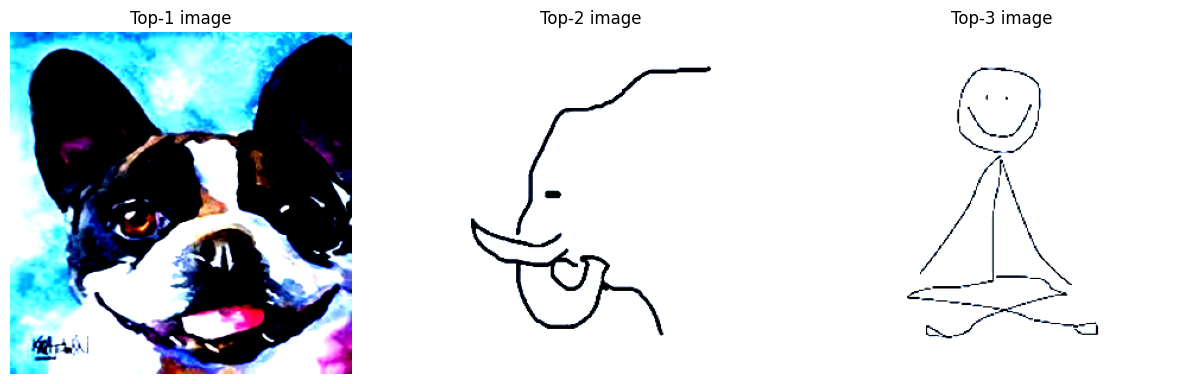

In [9]:
# Top-k images/stimuli in the PACS dataset that most activate a given neuron (channel)

activations = []
def get_activation(name):
  def hook(model, input, output):
    activations.append(output.detach())
  return hook

# Define the layer and channel
layer_number = getattr(vision_side, 'layer4')
block = layer_number[5]
conv3 = getattr(block, 'bn3')
neuron_index = 1512 # 1512 (bn3) is "happy", 1739 (conv3) is "evil"

hook = conv3.register_forward_hook(get_activation('layer_4_5_conv3')) # hook

# Process the images and record the activations
max_batches = 500 # number of batches

batch_count = 0
saved_images = []
with torch.no_grad():
  for inputs in dataloader:
    if batch_count >= max_batches:
      break

    images = inputs['images']
    saved_images.extend(images.cpu().numpy())

    images = images.to(dtype=torch.float32, device=device)
    _ = vision_side(images)

    batch_count += 1

hook.remove()
activations = torch.cat(activations, dim=0)

# Top-k images in the dataset
k = 3
neuron_activations = activations[:, neuron_index].mean(dim=(1, 2))
top_image_indices = torch.argsort(neuron_activations, descending=True)[:k]
topk_images = [saved_images[i] for i in top_image_indices]

# Show the top-k images
fig, axes = plt.subplots(1, len(topk_images), figsize=(15, 5))
if not isinstance(axes, (np.ndarray, list)):
  axes = [axes]

for i, image in enumerate(topk_images):
  ax = axes[i]
  ax.imshow(image.transpose(1, 2, 0))
  # ax.imshow(image)
  ax.set_title(f"Top-{i+1} image")
  ax.axis('off')

plt.savefig(f"results/dataset_samples_pacs_happy.png") # save the fig

plt.show()

## CLAP model

In [24]:
# CLAP model

# MS CLAP
model, tokenizer, args = CLAP(version='2023', use_cuda=True).load_clap() # -> changed the config file to use the Cnn14 architecture

# LAION CLAP
# model = laion_clap.CLAP_Module(enable_fusion=False, device=device) # -> the audio side here is implemented with transformers
# model.load_ckpt()

model.to(device).eval()

CLAP(
  (audio_encoder): AudioEncoder(
    (base): Cnn14(
      (spectrogram_extractor): Spectrogram(
        (stft): STFT(
          (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
          (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
        )
      )
      (logmel_extractor): LogmelFilterBank()
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block1): ConvBlock(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_block2): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [32]:
# Audio side of the CLAP model

# audio_side = model.model.audio_branch # LAION CLAP
audio_side = model.audio_encoder # MS CLAP

In [33]:
# Audio side model layers

layers = get_model_layers(audio_side)
print(layers)

['base', 'base_spectrogram_extractor', 'base_spectrogram_extractor_stft', 'base_spectrogram_extractor_stft_conv_real', 'base_spectrogram_extractor_stft_conv_imag', 'base_logmel_extractor', 'base_bn0', 'base_conv_block1', 'base_conv_block1_conv1', 'base_conv_block1_conv2', 'base_conv_block1_bn1', 'base_conv_block1_bn2', 'base_conv_block2', 'base_conv_block2_conv1', 'base_conv_block2_conv2', 'base_conv_block2_bn1', 'base_conv_block2_bn2', 'base_conv_block3', 'base_conv_block3_conv1', 'base_conv_block3_conv2', 'base_conv_block3_bn1', 'base_conv_block3_bn2', 'base_conv_block4', 'base_conv_block4_conv1', 'base_conv_block4_conv2', 'base_conv_block4_bn1', 'base_conv_block4_bn2', 'base_conv_block5', 'base_conv_block5_conv1', 'base_conv_block5_conv2', 'base_conv_block5_bn1', 'base_conv_block5_bn2', 'base_conv_block6', 'base_conv_block6_conv1', 'base_conv_block6_conv2', 'base_conv_block6_bn1', 'base_conv_block6_bn2', 'base_fc1', 'base_fc_audioset', 'projection', 'projection_linear1', 'projection

In [10]:
# Define the layer and neuron/channel for feature visualization -> this doesn't work, we will find a way to play with audio and specs

layer_name = "base_conv_block6_bn2"
neuron_channel_index = 6

batch_param_f = lambda: param.image(256, batch=1, decorrelate=True)
obj = objectives.neuron(layer_name, neuron_channel_index)

_ = render.render_vis(audio_side, obj, batch_param_f, show_inline=True)
# _ = render.render_vis(audio_side, "layer3_3_conv3:168", show_inline=True) # or this